In [1]:
from fastai.vision.all import *
from fastai import *

In [2]:
ls .

__notebook__.ipynb


In [3]:
path = Path('../input/semi-conductor-image-classification-second-stage/')

In [4]:
path.ls()

(#4) [Path('../input/semi-conductor-image-classification-second-stage/submission_sample.csv'),Path('../input/semi-conductor-image-classification-second-stage/test'),Path('../input/semi-conductor-image-classification-second-stage/defect_area.csv'),Path('../input/semi-conductor-image-classification-second-stage/train')]

In [5]:
f_get = partial(get_image_files,folders='train')

In [6]:
dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = f_get,
                    splitter = RandomSplitter(seed=42),
                    get_y = parent_label,
                    item_tfms = Resize(224),
                    batch_tfms=[*aug_transforms(max_warp=0.),Normalize.from_stats(*imagenet_stats)]
                   )

In [7]:
dls = dblocks.dataloaders(path,bs=32,num_workers=4)

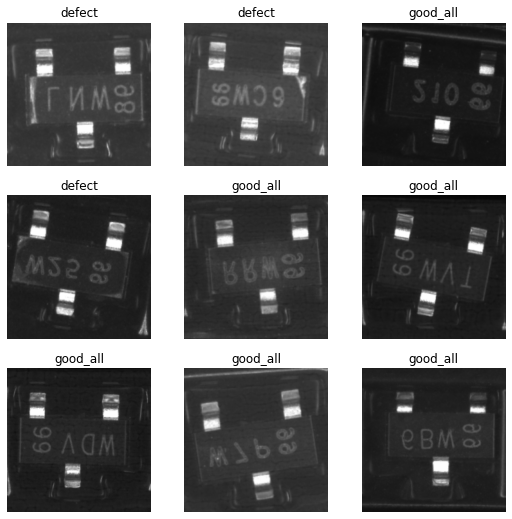

In [8]:
dls.show_batch(max_n=9)

In [9]:
def auc_roc_metrics(preds,targs):
    return RocAucBinary()(preds.argmax(dim=-1),targs)

In [10]:
learn = cnn_learner(dls,resnet50,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=7.585775847473997e-07)

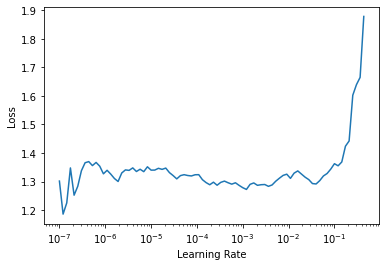

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,auc_roc_metrics,time


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10,lr_max=(1e-6/2,1e-5/2,1e-4/2))

In [ ]:
class OverSamplingCallback(Callback):
    def __init__(self,learn:Learner):
        super().__init__(learn)
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels,return_counts=True)
        self.weights = torch.DoubleTensor((1/counts)[self.labels])
        self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
        self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))

res50learner_upsample = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics, \
                      callback_fns = [partial(OverSamplingCallback)],
                      ).to_fp16()

In [ ]:
res50learner_upsample.fit_one_cycle(5,1e-3)

In [ ]:
res50learner_upsample.unfreeze()
res50learner_upsample.lr_find()

In [ ]:
res50learner_upsample.fit_one_cycle(10,lr_max=(1e-6/2,1e-5/2,1e-4/2))
#sadly, no any improvement

In [ ]:
df_test = pd.read_csv(path/'submission_sample.csv')

In [ ]:
def get_test_items(df,path):
    files = [str(path)+'/test/test_contest/test/'+x+'.bmp' for x in df['id']]
    return files

In [ ]:
test_dl = dls.test_dl(get_test_items(df_test,path))

In [ ]:
preds = learn.get_preds(dl=test_dl)

preds[0][:,0] #defect score for all test samples

In [ ]:
densenet121_learner = cnn_learner(dls,densenet121,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()
densenet169_learner = cnn_learner(dls,densenet169,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()
alexnet_learner = cnn_learner(dls,alexnet,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()
resnet34_learner = cnn_learner(dls,resnet34,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics).to_fp16()

In [ ]:
def train(arch,dls,num_epochs,loss_func=LabelSmoothingCrossEntropy(),metrics=auc_roc_metrics):
    learner = cnn_learner(dls,arch,loss_func,metrics).to_fp16()
    learner.fit_one_cycle(num_epochs, 1e-3)
    return learner

In [ ]:
densenet121_learner = train(densenet121,dls,5)
densenet169_learner = train(densenet169,dls,5)
resnet34_learner = train(resnet34,dls,5)

In [ ]:
alexnet_learner = train(alexnet,dls,5)

In [ ]:
import os
if not os.path.exists('/kaggle/models'):
    os.mkdir('/kaggle/models')
learn.save('/kaggle/models/res50')
densenet121_learner.save('/kaggle/models/dense121')
densenet169_learner.save('/kaggle/models/dense169')
resnet34_learner.save('/kaggle/models/res34')
res50learner_upsample.save('/kaggle/models/res50_upsample')

In [ ]:
def generate_results(test_dl, df_test, *learners):
        
    resnet50_preds = learn.get_preds(dl=test_dl)[0][:,0]
    densenet121_preds = densenet121_learner.get_preds(dl = test_dl)[0][:,0]
    densenet169_preds = densenet169_learner.get_preds(dl = test_dl)[0][:,0]
    alexnet_preds = alexnet_learner.get_preds(dl = test_dl)[0][:,0]
    #resnet34_preds = resnet34_learner.get_preds(dl = test_dl)[0][:,0]
    #ensemble prediction
    ens_preds = (resnet50_preds+densenet121_preds+densenet169_preds+resnet34_preds)/4
    
    result = {'id': [], 'defect_score': []}
    
    for fname,score in zip(df_test['id'],ens_preds.tolist()):
        result['id'].append(fname)
        result['defect_score'].append(score)
    
    #make submission csv
    submission = pd.DataFrame(result)
    submission.to_csv('submission_ens4.csv', index=False)

generate_results(test_dl, df_test,[learn,densenet121_learner,densenet169_learner,alexnet_learner])

In [ ]:
def generate_single_result(test_dl, df_test, learner, tta=False):
    if tta:
        preds = learner.tta(dl=test_dl)[0][:,0].tolist()
    else:
        preds = learner.get_preds(dl=test_dl)[0][:,0].tolist()
    
    result = {'id': [], 'defect_score': []}

    for fname,score in zip(df_test['id'],preds):
        result['id'].append(fname)
        result['defect_score'].append(score)
    
    submission = pd.DataFrame(result)
    submission.to_csv(f'submission_single.csv', index=False)

In [ ]:
generate_single_result(test_dl,df_test,learn,tta=True)

In [ ]:
# generate_single_result(test_dl,df_test,densenet121_learner)
# generate_single_result(test_dl,df_test,densenet169_learner)
# generate_single_result(test_dl,df_test,alexnet_learner)
generate_single_result(test_dl,df_test,resnet34_learner)

In [ ]:
#learn.save('/kaggle/working/res50-baseline')

In [ ]:
#from IPython.display import FileLinks

In [ ]:
#FileLinks('.')

./submission_<fastai.learner.Learner object at 0x7f83aebca990>.csv  -->resnet50
./submission_<fastai.learner.Learner object at 0x7f835fc24a90>.csv  -->densenet121
./submission_<fastai.learner.Learner object at 0x7f835f806a50>.csv  -->densenet169
./submission_<fastai.learner.Learner object at 0x7f83c1516f90>.csv -->alexnet
./submission_<fastai.learner.Learner object at 0x7f8386e10e50>.csv -->res34